Loading Model and Data

In [ ]:
# load model and data from huggingface

import os
import sys
import numpy as np
import torch
from datasets import load_dataset
from transformers import Wav2Vec2Model, Wav2Vec2FeatureExtractor

# load pretrained model (here wav2vec2)
# you can find many other models on huggingface.co
processor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")

# load data
# you can find many other datasets on huggingface.co
dataset = load_dataset("AbstractTTS/SAVEE")

#prepapre an example dataset
data = dataset['train']
# data = data.filter(lambda example: example["emotion"] in range(8))
data = data.shuffle(seed=42)
num_samples = min(500, len(data))
data = data.select(range(num_samples))
# save labels for later analysis
np.save("outputs/labels.npy", data["emotion"])

print(data)

Dataset({
    features: ['file', 'audio', 'gender', 'transcription', 'emotion', 'speaking_rate', 'pitch_mean', 'pitch_std', 'rms', 'relative_db'],
    num_rows: 480
})


Feature Extraction

In [ ]:
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu" # you should use a GPU for this task, otherwise it will be very slow

def extract_features(model, processor, dataset, output_dir, num_layers=13, num_features=768):
    model.to(device)

    #initialize hidden states tensor to avoid itereative concatenation which is very slow
    hidden_states = torch.zeros((len(dataset), num_layers, num_features))

    # iterate over the dataset
    for i, example in enumerate(tqdm(dataset)):
        #preprocess the data, check your data how to call your audio file (here it is ["audio"]["array"])
        inputs = processor(example["audio"]["array"], return_tensors="pt", padding='max_length', max_length=16000, sampling_rate=16000).input_values.to(device)

        with torch.no_grad():
            outputs = model(inputs, output_hidden_states=True, return_dict=True)

        # average the hidden states over the time axis for each layer j
        for j, hidden_state in enumerate(outputs.hidden_states):
            hs_mean = torch.mean(hidden_state, dim=1)
            hidden_states[i, j] = hs_mean

        #optional saving after 100 steps
        # depending on the size of your dataset this process can time out so better save intermediate results
        if i>0 and i%100 == 0:
            np.save(os.path.join(output_dir, f"hidden_states.npy"), hidden_states.cpu().numpy())

    np.save(os.path.join(output_dir, f"hidden_states.npy"), hidden_states.cpu().numpy())


# run a small experiment with 100 random samples

extract_features(model, processor, data, "outputs")

100%|██████████| 480/480 [09:22<00:00,  1.17s/it]


Feature Visualization

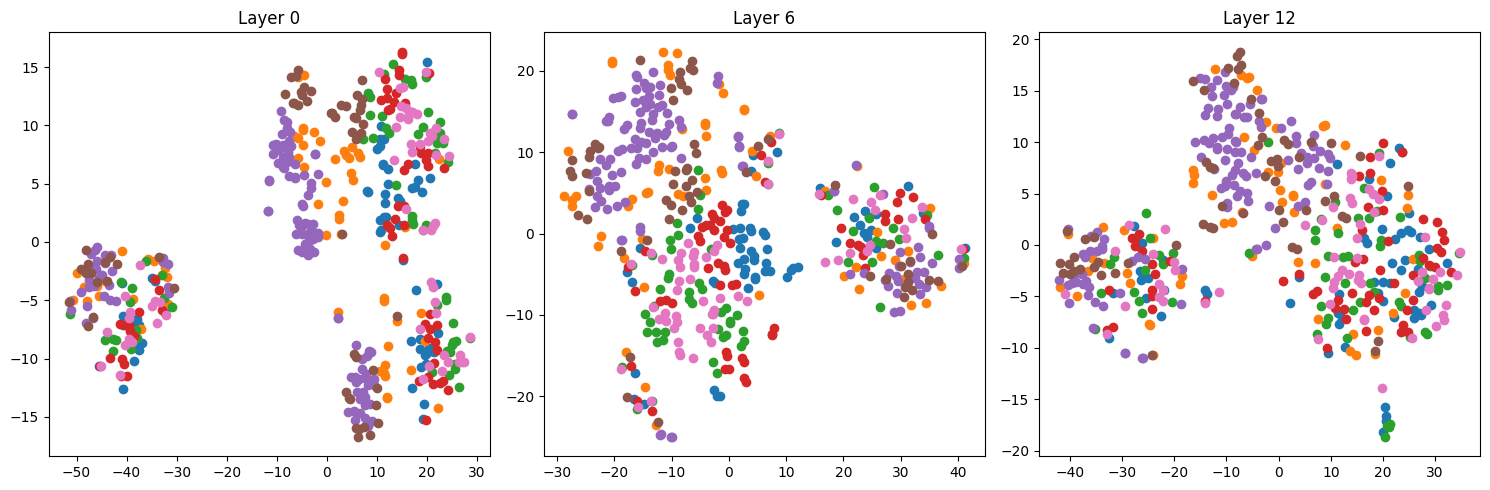

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# lets load the hidden states and check the shape
hidden_states = np.load("outputs/hidden_states.npy")
labels = np.load("outputs/labels.npy")
unique_labels = np.unique(labels)

# visualize the hidden states using tsne of a few layers
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, layer in enumerate([0, 6, 12]):
    X_embedded = TSNE().fit_transform(hidden_states[:, layer, :])
    ax = axes[idx]
    for i in range(len(unique_labels)):
        ax.scatter(X_embedded[labels == unique_labels[i], 0], X_embedded[labels == unique_labels[i], 1], marker='o')
    ax.set_title(f"Layer {layer}")

plt.tight_layout()
plt.show()

#### Similarity Tests

similarity metrics code

In [ ]:
import torch
from sklearn.metrics.pairwise import linear_kernel
import numpy as np


### TAKEN FROM HERE: https://github.com/minyoungg/platonic-rep/blob/main/metrics.py

## mutual KNN
def compute_nearest_neighbors(feats, topk=1):
    """
    Compute the nearest neighbors of feats
    Args:
        feats: a torch tensor of shape N x D
        topk: the number of nearest neighbors to return
    Returns:
        knn: a torch tensor of shape N x topk
    """
    assert feats.ndim == 2, f"Expected feats to be 2D, got {feats.ndim}"
    knn = (
        (feats @ feats.T).fill_diagonal_(-1e8).argsort(dim=1, descending=True)[:, :topk]
    )
    return knn

def mutual_knn(feats_A, feats_B, topk):
    """
    Computes the mutual KNN accuracy.

    Args:
        feats_A: A torch tensor of shape N x feat_dim
        feats_B: A torch tensor of shape N x feat_dim

    Returns:
        A float representing the mutual KNN accuracy
    """
    knn_A = compute_nearest_neighbors(feats_A, topk)
    knn_B = compute_nearest_neighbors(feats_B, topk)

    n = knn_A.shape[0]
    topk = knn_A.shape[1]

    # Create a range tensor for indexing
    range_tensor = torch.arange(n, device=knn_A.device).unsqueeze(1)

    # Create binary masks for knn_A and knn_B
    lvm_mask = torch.zeros(n, n, device=knn_A.device)
    llm_mask = torch.zeros(n, n, device=knn_A.device)

    lvm_mask[range_tensor, knn_A] = 1.0
    llm_mask[range_tensor, knn_B] = 1.0

    acc = (lvm_mask * llm_mask).sum(dim=1) / topk

    return acc.mean().item()


## CKA
def hsic_unbiased(K, L):
    """
    Compute the unbiased Hilbert-Schmidt Independence Criterion (HSIC) as per Equation 5 in the paper.
    > Reference: https://jmlr.csail.mit.edu/papers/volume13/song12a/song12a.pdf
    """
    m = K.shape[0]

    # Zero out the diagonal elements of K and L
    K_tilde = K.clone().fill_diagonal_(0)
    L_tilde = L.clone().fill_diagonal_(0)

    # Compute HSIC using the formula in Equation 5
    HSIC_value = (
        (torch.sum(K_tilde * L_tilde.T))
        + (torch.sum(K_tilde) * torch.sum(L_tilde) / ((m - 1) * (m - 2)))
        - (2 * torch.sum(torch.mm(K_tilde, L_tilde)) / (m - 2))
    )

    HSIC_value /= m * (m - 3)
    return HSIC_value


def hsic_biased(K, L):
    """ Compute the biased HSIC (the original CKA) """
    H = torch.eye(K.shape[0], dtype=K.dtype, device=K.device) - 1 / K.shape[0]
    return torch.trace(K @ H @ L @ H)

def cka(feats_A, feats_B, kernel_metric='ip', rbf_sigma=1.0, unbiased=False):
        """Computes the unbiased Centered Kernel Alignment (CKA) between features."""

        if kernel_metric == 'ip':
            # Compute kernel matrices for the linear case
            K = torch.mm(feats_A, feats_A.T)
            L = torch.mm(feats_B, feats_B.T)
        elif kernel_metric == 'rbf':
            # COMPUTES RBF KERNEL
            K = torch.exp(-torch.cdist(feats_A, feats_A) ** 2 / (2 * rbf_sigma ** 2))
            L = torch.exp(-torch.cdist(feats_B, feats_B) ** 2 / (2 * rbf_sigma ** 2))
        else:
            raise ValueError(f"Invalid kernel metric {kernel_metric}")

        # Compute HSIC values
        hsic_fn = hsic_unbiased if unbiased else hsic_biased
        hsic_kk = hsic_fn(K, K)
        hsic_ll = hsic_fn(L, L)
        hsic_kl = hsic_fn(K, L)

        # Compute CKA
        #print('hsic', hsic_kl)
        cka_value = hsic_kl / (torch.sqrt(hsic_kk * hsic_ll) + 1e-6)
        return cka_value.item()


def cosine_similarity(feats_A, feats_B):
    """
    Compute the cosine similarity between two sets of features.
    Args:
        feats_A: a torch tensor of shape N x D
        feats_B: a torch tensor of shape N x D
    Returns:
        a torch tensor of shape N x N
    """
    assert feats_A.ndim == 2, f"Expected feats_A to be 2D, got {feats_A.ndim}"
    assert feats_B.ndim == 2, f"Expected feats_B to be 2D, got {feats_B.ndim}"
    feats_A = feats_A / torch.norm(feats_A, dim=1, keepdim=True)
    feats_B = feats_B / torch.norm(feats_B, dim=1, keepdim=True)
    return feats_A @ feats_B.T

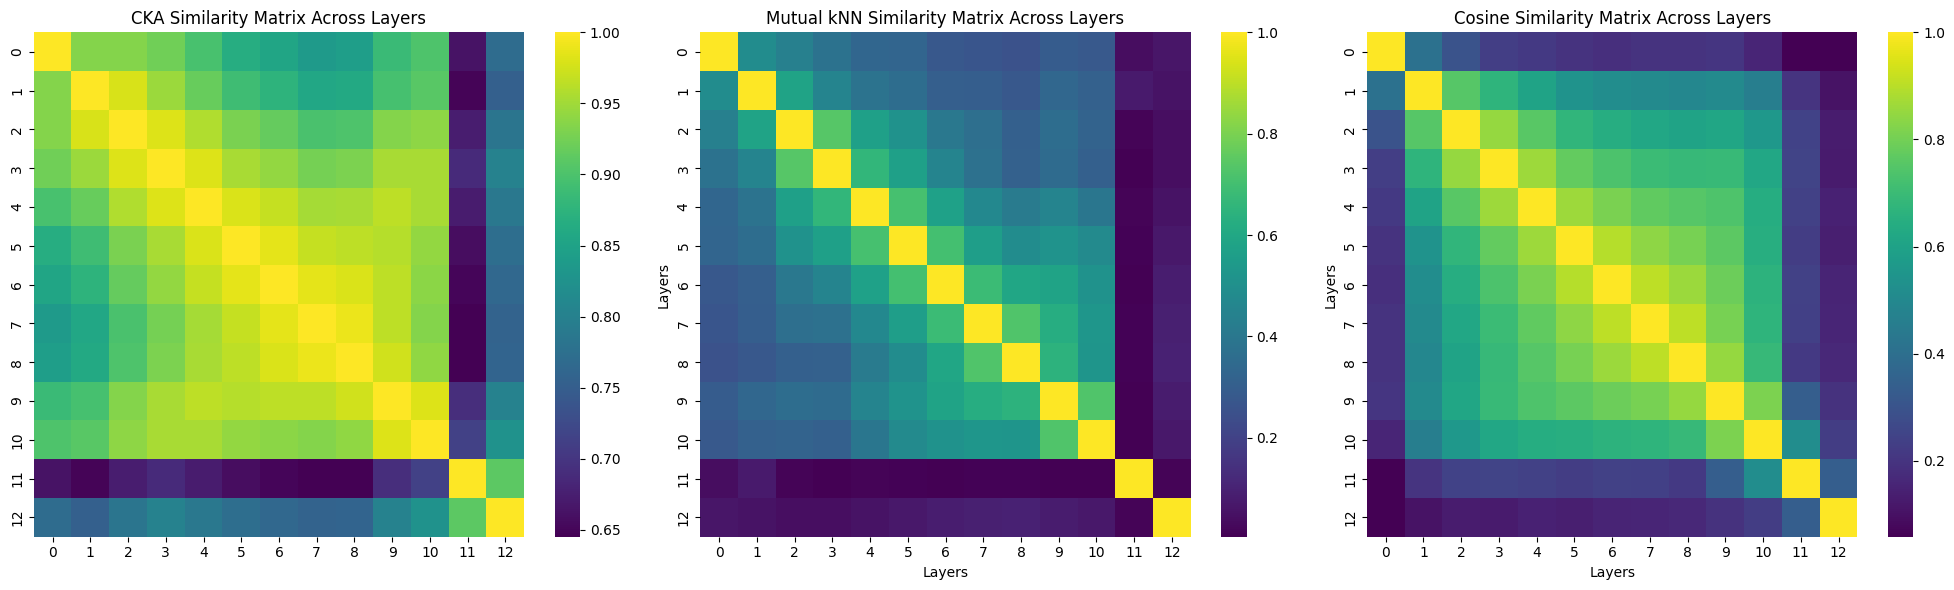

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

hidden_states = np.load("outputs/hidden_states.npy")

num_layers = hidden_states.shape[1]
num_samples = hidden_states.shape[0]
hidden_states = torch.tensor(hidden_states)

cka_matrix = np.zeros((num_layers, num_layers))
for i in range(num_layers):
    for j in range(num_layers):
        cka_matrix[i, j] = cka(hidden_states[:, i, :], hidden_states[:, j, :])

knn_matrix = np.zeros((num_layers, num_layers))
for i in range(num_layers):
    for j in range(num_layers):
        knn_matrix[i, j] = mutual_knn(hidden_states[:, i, :], hidden_states[:, j, :], topk=5)


# Compute cosine similarity
cosine_matrix = np.zeros((num_layers, num_layers))
for i in range(num_layers):
    for j in range(num_layers):
        cosine_matrix[i, j] = cosine_similarity(hidden_states[:, i, :], hidden_states[:, j, :]).trace()/num_samples


fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.heatmap(cka_matrix, ax=axes[0], cmap="viridis")
axes[0].set_title("CKA Similarity Matrix Across Layers")

sns.heatmap(knn_matrix, ax=axes[1], cmap="viridis")
axes[1].set_title("Mutual kNN Similarity Matrix Across Layers")
axes[1].set_xlabel("Layers")
axes[1].set_ylabel("Layers")

sns.heatmap(cosine_matrix, ax=axes[2], cmap="viridis")
axes[2].set_title("Cosine Similarity Matrix Across Layers")
axes[2].set_xlabel("Layers")
axes[2].set_ylabel("Layers")

plt.tight_layout()
plt.show()

### Convexity Analysis

In [ ]:
!pip install pynndescent

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 1.3 MB/s eta 0:00:00


In [ ]:
import os
import glob
import numpy as np
import torch
import pynndescent
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra
from typing import Dict, List, Tuple
import itertools
import random

#fix random seed
random.seed(42)

def nn(features, num_neig):
    m,n = features.shape
    dis = np.zeros((m,m))
    index = pynndescent.NNDescent(features, n_neighbors=num_neig+1, metric='euclidean', n_jobs=-1)
    ind = index.neighbor_graph[0]
    distances = index.neighbor_graph[1]
    for i in range(m):
        dis[i,ind[i]] = distances[i]
    dis_sym = np.maximum(dis, dis.T)
    return dis_sym

def get_path(Pr: np.ndarray, i: int, j: int) -> List[int]:
    """
    Get the shortest path from i to j.
    Source: https://stackoverflow.com/a/5307890
    """
    path = [j]
    k = j
    while Pr[i, k] != -9999:
        path.append(Pr[i, k])
        k = Pr[i, k]
    return path[::-1]

def get_concept_idx(labels,
                    ) -> Dict[str, List[int]]:
    """
    Arguments:
        labels          List of all classes
    Returns:
        concepts        Dictionary of ids from columns_names belonging to each concept
    """
    classes = np.unique(labels)

    class_dic = {}
    for idx, name in enumerate(labels):
        for key in classes:
            if name == key:
                if key in class_dic.keys():
                    class_dic[key].append(idx)
                else:
                    class_dic[key] = [idx]
    return class_dic


def is_path_in_concept(shortest_path, indices):
    """
    Compute the proportion of the path that is within the concept.
    Arguments:
        shortest_path:  list of all vertices on the path
        indices:        list of all vertices belonging to the concept
    Returns:
        prop:           the proportion of the path that is inside the concept
    """

    if len(shortest_path) <= 2:
        prop = 1
    else:
        length = 0
        outside = 0
        for idx in shortest_path[1:-1]:
            length += 1
            if idx not in indices:
                outside += 1
        prop = (length - outside)/length
    return prop

def compute_paths(dist_matrix, concept, indices, predecessors):
    """
    dist_matrix     output from djikstra
    concept         name of concept
    indices         indeces of all points beloning to concept
    predecessores   output from dijkstra
    """
    proportion = []
    path_exists = []
    all_paths = list(itertools.permutations(indices, r=2))
    n_paths_max = min(len(all_paths), 5000)
    sampled_indices = np.random.choice(list(range(len(all_paths))), n_paths_max, replace=False)
    sampled_paths = [all_paths[index] for index in sampled_indices]
    for id1, id2 in sampled_paths:
        if dist_matrix[id1, id2] == float('inf'):
            exists = False
            proportion.append(0)
        else:
            shortest_path = get_path(predecessors, id1, id2)
            prop = is_path_in_concept(shortest_path, indices)
            proportion.append(prop)
            exists = True
        path_exists.append(exists)
    #print(f"Concept {concept}: "
    #      f"{'{:.2f}'.format(np.mean(proportion) * 100)}% mean proportion of path in concept")
    return proportion, path_exists

def extract_indices(labels: List[str], min_per_class) -> Dict[str, List[int]]:
    class_counts = {}
    for label in labels:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1

    indices = []
    for label, count in class_counts.items():
        if count > min_per_class:
            indices.append([i for i, l in enumerate(labels) if l == label])

    return indices

def graph_convexity(features, labels, num_neighbours=10):
    """
    Arguments:
        features:       3D tensor of shape (n_samples, n_layers, n_features)
        labels:         list of all classes
        num_neighbours: number of neighbours to consider in the graph
    Returns:
        proportion_all: list of tuples (mean, std) of the proportion of the path that is within the concept averaged across classes
        proportion_class_all: dictionary of dictionaries with the proportion of the path that is within the concept
    """
    proportion_all = []
    proportion_class_all = {}
    num_layers = features.shape[1]
    for lay in range(num_layers):
        print(f"Start Layer {lay}")
        prop = []
        proportion_class = {}
        dis_sym = nn(features[:,lay,:], num_neighbours)
        graph = csr_matrix(dis_sym)
        concept_indices = get_concept_idx(labels)
        dist_matrix, predecessors = dijkstra(csgraph=graph, directed=True,
                                                    return_predecessors=True)
        for concept, indices in concept_indices.items():
            proportion, path_exists = compute_paths(dist_matrix,concept,indices,predecessors)
            prop.extend(proportion)
            proportion_class[concept] = (np.mean(proportion), np.std(proportion)/ np.sqrt(len(indices)))
        proportion_all.append((np.mean(prop), np.std(prop)/ np.sqrt(len(indices))))
        proportion_class_all[f'Layer {lay}'] = proportion_class
        print(f"Layer {lay}: ", proportion_all[-1])

    return proportion_all, proportion_class_all

Start Layer 0
Layer 0:  (0.3725590701219513, 0.05730784012039865)
Start Layer 1
Layer 1:  (0.4506922364982578, 0.053289118779513395)
Start Layer 2
Layer 2:  (0.3885194359756098, 0.0586897267296333)
Start Layer 3
Layer 3:  (0.5111432019454123, 0.053778892801253274)
Start Layer 4
Layer 4:  (0.5330510489256678, 0.05457198875003137)
Start Layer 5
Layer 5:  (0.5717854420731707, 0.055750197649054214)
Start Layer 6
Layer 6:  (0.5833612804878049, 0.05496216261278159)
Start Layer 7
Layer 7:  (0.610254700203252, 0.05533924256795586)
Start Layer 8
Layer 8:  (0.5932310721544716, 0.05589391080244524)
Start Layer 9
Layer 9:  (0.5468883384146341, 0.055552218201412214)
Start Layer 10
Layer 10:  (0.5280531358885017, 0.055542180897184816)
Start Layer 11
Layer 11:  (0.4004806366144018, 0.051520725619825444)
Start Layer 12
Layer 12:  (0.4099647031068525, 0.05297740218990148)


Text(0.5, 1.0, 'Convexity of Words Across Layers')

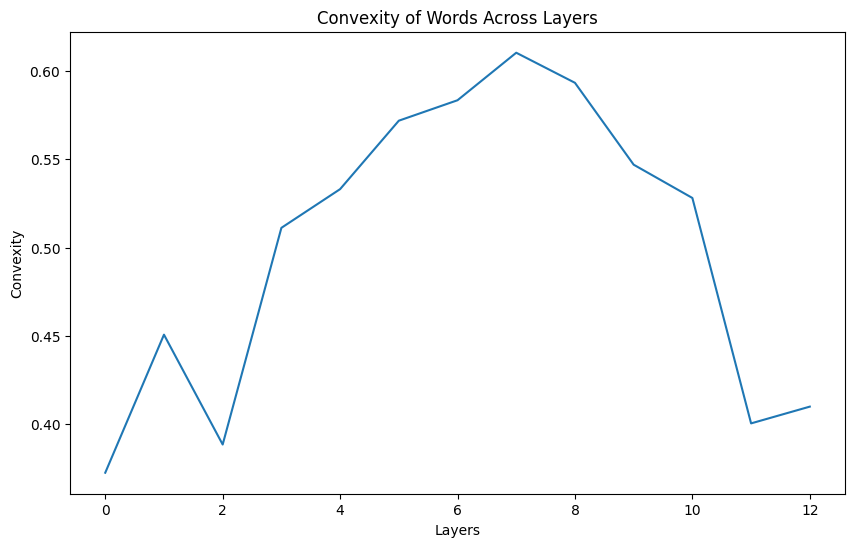

In [ ]:
hidden_states = np.load("outputs/hidden_states.npy")
labels = np.load("outputs/labels.npy")

# Compute convexity, this can take some time depending on the size of the dataset
convexity,_ = graph_convexity(hidden_states, labels, num_neighbours=10)

plt.figure(figsize=(10, 6))
plt.plot([x[0] for x in convexity])
plt.xlabel("Layers")
plt.ylabel("Convexity")
plt.title("Convexity of Words Across Layers")